In [3]:
!git clone https://github.com/meghdadk/SCRUB.git

Cloning into 'SCRUB'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 94 (delta 29), reused 91 (delta 26), pack-reused 0
Unpacking objects: 100% (94/94), 780.51 KiB | 4.09 MiB/s, done.
/kaggle/working/SCRUB


In [13]:
%cd /kaggle/working/SCRUB

/kaggle/working/SCRUB


In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression

import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import wandb

from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

/tmp/ipykernel_629/4131731215.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
def pdb():
    import pdb
    pdb.set_trace

def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

In [8]:
!mkdir data; cd data; gdown "1z4BYvq71Y-9CEY1kSphlZm0u6qgMn8JI"; unzip lacuna100.zip

Downloading...
From (original): https://drive.google.com/uc?id=1z4BYvq71Y-9CEY1kSphlZm0u6qgMn8JI
From (redirected): https://drive.google.com/uc?id=1z4BYvq71Y-9CEY1kSphlZm0u6qgMn8JI&confirm=t&uuid=a41658d7-cf6e-4950-939c-27a2f64e5275
To: /kaggle/working/SCRUB/data/lacuna100.zip
100%|████████████████████████████████████████| 140M/140M [00:04<00:00, 33.5MB/s]
Archive:  lacuna100.zip
   creating: lacuna100/test/
  inflating: lacuna100/test/data.npy  
  inflating: lacuna100/test/label.npy  
   creating: lacuna100/train/
  inflating: lacuna100/train/data.npy  
  inflating: lacuna100/train/label.npy  


In [14]:
!rm main.py; gdown 1mK5b3TFetCqXKAGB4ucXdZn8QfceQE_l

rm: cannot remove 'main.py': No such file or directory
Downloading...
From (original): https://drive.google.com/uc?id=1mK5b3TFetCqXKAGB4ucXdZn8QfceQE_l
From (redirected): https://drive.google.com/uc?id=1mK5b3TFetCqXKAGB4ucXdZn8QfceQE_l&confirm=t&uuid=423f3038-bf7f-4139-8847-72aa883f2572
To: /kaggle/working/SCRUB/main.py
100%|██████████████████████████████████████| 11.6k/11.6k [00:00<00:00, 33.1MB/s]


In [15]:
%run main.py --dataset lacuna100 --dataroot=data/lacuna100/ --model allcnn --filters 1.0 --lr 0.1 --lossfn ce --num-classes 100

Checkpoint name: lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_training]
confuse mode: False
split mode: None
Number of Classes: 100
[0] train metrics:{"loss": 3.833097564697266, "error": 0.90684375}
Learning Rate : 0.1
[0] dry_run metrics:{"loss": 3.279474970817566, "error": 0.81759375}
Learning Rate : 0.1
[0] test metrics:{"loss": 3.31660671043396, "error": 0.8255}
Learning Rate : 0.1
Epoch Time: 27.75 sec
[1] train metrics:{"loss": 2.968328638076782, "error": 0.7465}
Learning Rate : 0.1
Epoch Time: 13.24 sec
[2] train metrics:{"loss": 2.3372919545173647, "error": 0.581875}
Learning Rate : 0.1
Epoch Time: 13.21 sec
[3] train metrics:{"loss": 1.9414231042861938, "error": 0.4595625}
Learning Rate : 0.1
Epoch Time: 13.21 sec
[4] train metrics:{"loss": 1.6677791953086853, "error": 0.3660625}
Learning Rate : 0.1
Epoch Time: 13.22 sec
[5] train metrics:{"loss": 1.4794699716567994, "err

In [17]:
!cd data; gdown "1ziLZBOaAwWOQLShgdBuRljF0ykXmONOS"; unzip lacuna10.zip

Downloading...
From: https://drive.google.com/uc?id=1ziLZBOaAwWOQLShgdBuRljF0ykXmONOS
To: /kaggle/working/SCRUB/data/lacuna10.zip
100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 17.0MB/s]
Archive:  lacuna10.zip
   creating: lacuna10/test/
  inflating: lacuna10/test/data.npy  
  inflating: lacuna10/test/label.npy  
   creating: lacuna10/train/
  inflating: lacuna10/train/data.npy  
  inflating: lacuna10/train/label.npy  


In [6]:
%run main.py --dataset small_lacuna6 --model allcnn --dataroot=data/lacuna10/ --filters 1.0 --lr 0.001 \
--resume checkpoints/lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 3

Checkpoint name: small_lacuna6_allcnn_1_0_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in small_lacuna6_allcnn_1_0_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Number of Classes: 6
[0] train metrics:{"loss": 1.795213861465454, "error": 0.8583333333333333}
Learning Rate : 0.001
[0] test metrics:{"loss": 1.7344008684158325, "error": 0.8133333331843218}
Learning Rate : 0.001
Epoch Time: 2.01 sec
[1] train metrics:{"loss": 1.7051752789815267, "error": 0.8149999998013179}
Learning Rate : 0.001
Epoch Time: 0.26 sec
[2] train metrics:{"loss": 1.5626048628489178, "error": 0.625}
Learning Rate : 0.001
Epoch Time: 0.25 sec
[3] train metrics:{"loss": 1.4044797770182291, "error": 0.4399999992052714}
Learning Rate : 0.001
Epoch Time: 0.26 sec
[4] train metrics:{"loss": 1.2349496428171793, "error": 0.3266666611035665}
Learning Rate : 0.001
Epoch Time: 0.25 sec
[5] train metrics:{"loss": 1.069617125193278, "error": 0.2866666618982951}
Lear

In [16]:
%run main.py --dataset small_lacuna6 --model allcnn --dataroot=data/lacuna10/ --filters 1.0 --lr 0.001 \
--resume checkpoints/lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 \
--forget-class 0,1,2,3,4,5 --num-to-forget 300 --seed 3

Checkpoint name: small_lacuna6_allcnn_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in small_lacuna6_allcnn_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Replacing indexes [449 141 131 311 176 134 551 152 123 317 515  67 519  65 396 321 221 309
  55 265 514 546 368 510 590 204 312 142 397 226 188 227 146 180 223  80
 205 194  77 369 200 155 136 543 327  16 398 535 469 533 518 294  72 297
  13 171 258 445  40 222   1  30 120 248 280 235 577 414 378 212 246 172
 268 108 389 467 395 232  89  62 109 441  84 182 343 484 157 418 167 244
 374 457 520 437 159 575 198 345  60 300 439 285 567 481 116 482 161 426
   3 479 344 273 419  32 203 158 284  18  53 129 331 286 130 178 403 448
 173 407 202 362  66 402 281 568 491 225  28 267 209 251 103  20 137 486
 372 112 193 250 183 513   7 352 165 525 410 275 552  24  38 276 150  41
 430  94 413 394  23  12 562 381 160 393 100 391 572 548  1

In [17]:
log_dict={}
training_epochs=30

log_dict['epoch']=training_epochs

parameter_count(copy.deepcopy(model))

Total Number of Parameters: 1619238


In [18]:
import copy
model0 = copy.deepcopy(model)
model_initial = copy.deepcopy(model)

arch = args.model 
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - 300#num_to_forget
seed = args.seed
unfreeze_start = None

learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load(m_name))
model0.load_state_dict(torch.load(m0_name))
model_initial.load_state_dict(torch.load(init_checkpoint))

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

model.cuda()
model0.cuda()


for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

In [20]:
log_dict['args']=args

In [19]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [21]:
log_dict['dist_Original_Retrain']=distance(model,model0)

Distance: 0.34664725914112865
Normalized Distance: 0.005233092416827058


In [22]:
def ntk_init(resume,seed=1):
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args.device)
    model_init.load_state_dict(torch.load(resume))
    return model_init

In [23]:
model_init = ntk_init(init_checkpoint,args.seed)
for p in model_init.parameters():
    p.data0 = p.data.clone()

In [24]:
log_dict['dist_Original_Original_init']=distance(model_init,model)

Distance: 1.1624024681825136
Normalized Distance: 0.017564380842997124


In [25]:
args.retain_bs = 32
args.forget_bs = 64

In [26]:
train_loader_full, valid_loader_full, test_loader_full   = datasets.get_loaders(dataset, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

confuse mode: False
split mode: train
confuse mode: False
split mode: train
Replacing indexes [449 141 131 311 176 134 551 152 123 317 515  67 519  65 396 321 221 309
  55 265 514 546 368 510 590 204 312 142 397 226 188 227 146 180 223  80
 205 194  77 369 200 155 136 543 327  16 398 535 469 533 518 294  72 297
  13 171 258 445  40 222   1  30 120 248 280 235 577 414 378 212 246 172
 268 108 389 467 395 232  89  62 109 441  84 182 343 484 157 418 167 244
 374 457 520 437 159 575 198 345  60 300 439 285 567 481 116 482 161 426
   3 479 344 273 419  32 203 158 284  18  53 129 331 286 130 178 403 448
 173 407 202 362  66 402 281 568 491 225  28 267 209 251 103  20 137 486
 372 112 193 250 183 513   7 352 165 525 410 275 552  24  38 276 150  41
 430  94 413 394  23  12 562 381 160 393 100 391 572 548  15 465 307 322
 471  76 599 314 408 384 574 456 440 556 559 399 585 295 199  69  14 231
 340 517 488 356 582 192 365 306 409 236  10 438  37 382   2  25  52 500
 521 347 166 330 588 508 177 2

In [27]:
print (len(forget_loader.dataset))
print (len(retain_loader.dataset))
print (len(test_loader_full.dataset))
print (len(train_loader_full.dataset))
from collections import Counter
print(dict(Counter(train_loader_full.dataset.targets)))

300
300
600
600
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}


In [28]:
args.optim = 'adam'
args.gamma = 1
args.alpha = 0.5
args.beta = 0
args.smoothing = 0.5
args.msteps = 3
args.clip = 0.2
args.sstart = 10
args.kd_T = 2
args.distill = 'kd'

args.sgda_epochs = 10
args.sgda_learning_rate = 0.0005
args.lr_decay_epochs = [5,8,9]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 0.1#5e-4
args.sgda_momentum = 0.9

In [29]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [30]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [31]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [32]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    swa_model.cuda()

In [24]:
!cd /kaggle/working/SCRUB/thirdparty/repdistiller/helper; rm loops.py; gdown "1RMWmrV6J6Uk6nOKwj7L87D3OAnXgytUZ"

Downloading...
From (original): https://drive.google.com/uc?id=1RMWmrV6J6Uk6nOKwj7L87D3OAnXgytUZ
From (redirected): https://drive.google.com/uc?id=1RMWmrV6J6Uk6nOKwj7L87D3OAnXgytUZ&confirm=t&uuid=48a345cb-bc08-430f-a477-7af96f83647c
To: /kaggle/working/SCRUB/thirdparty/repdistiller/helper/loops.py
100%|██████████████████████████████████████| 36.4k/36.4k [00:00<00:00, 71.3MB/s]


In [25]:
acc_rs = []
acc_fs = []
acc_ts = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> scrub unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, args, "minimize",)
    if epoch >= args.sstart:
        swa_model.update_parameters(model_s)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))

==> scrub unlearning ...


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 80.333 
maximize loss: -0.43	 minimize loss: 7.76	 train_acc: 80.33333587646484
==> scrub unlearning ...
 * Acc@1 96.333 
maximize loss: 8.72	 minimize loss: 14.91	 train_acc: 96.33333587646484
==> scrub unlearning ...
 * Acc@1 97.667 
maximize loss: 16.47	 minimize loss: 21.76	 train_acc: 97.66667175292969
==> scrub unlearning ...
 * Acc@1 98.667 
maximize loss: 0.00	 minimize loss: 25.54	 train_acc: 98.66667175292969
==> scrub unlearning ...
 * Acc@1 99.333 
maximize loss: 0.00	 minimize loss: 28.83	 train_acc: 99.33333587646484
==> scrub unlearning ...
 * Acc@1 100.000 
maximize loss: 0.00	 minimize loss: 30.81	 train_acc: 100.0
==> scrub unlearning ...
 * Acc@1 100.000 
maximize loss: 0.00	 minimize loss: 31.08	 train_acc: 100.0
==> scrub unlearning ...
 * Acc@1 99.667 
maximize loss: 0.00	 minimize loss: 31.35	 train_acc: 99.66667175292969
==> scrub unlearning ...
 * Acc@1 100.000 
maximize loss: 0.00	 minimize loss: 31.49	 train_acc: 100.0
==> scrub unlearning ...
 * Acc

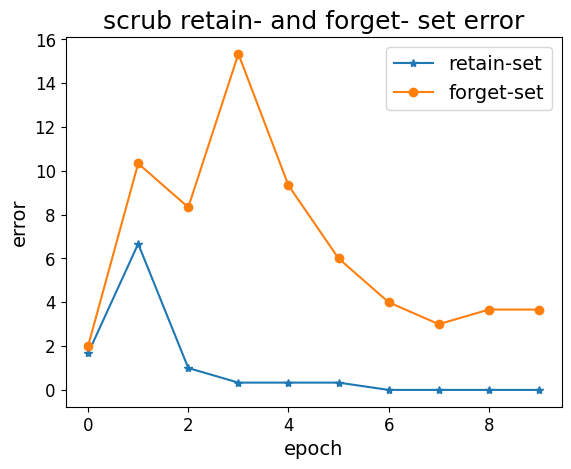

In [26]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('scrub retain- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

In [33]:
def delta_w_utils(model_init,dataloader,name='complete'):
    model_init.eval()
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    G_list = []
    f0_minus_y = []
    for idx, batch in enumerate(dataloader):#(tqdm(dataloader,leave=False)):
        batch = [tensor.to(next(model_init.parameters()).device) for tensor in batch]
        input, target = batch
        if 'mnist' in args.dataset:
            input = input.view(input.shape[0],-1)
        target = target.cpu().detach().numpy()
        output = model_init(input)
        G_sample=[]
        for cls in range(num_classes):
            grads = torch.autograd.grad(output[0,cls],model_init.parameters(),retain_graph=True)
            grads = np.concatenate([g.view(-1).cpu().numpy() for g in grads])
            G_sample.append(grads)
            G_list.append(grads)
        if args.lossfn=='mse':
            p = output.cpu().detach().numpy().transpose()
            #loss_hess = np.eye(len(p))
            target = 2*target-1
            f0_y_update = p-target
        elif args.lossfn=='ce':
            p = torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().transpose()
            p[target]-=1
            f0_y_update = copy.deepcopy(p)
        f0_minus_y.append(f0_y_update)
    return np.stack(G_list).transpose(),np.vstack(f0_minus_y)

In [28]:
from sys import getsizeof

In [14]:
!ls /tmp/NTK_data

G.npy  G_f.npy	G_r.npy  f0_minus_y.npy  f0_minus_y_f.npy  f0_minus_y_r.npy


In [ ]:
ntk_time = 0
model_init = ntk_init(init_checkpoint,args.seed)
t1 = time.time()
G_r,f0_minus_y_r = delta_w_utils(copy.deepcopy(model),retain_loader,'complete')
t2 = time.time()
ntk_time += t2-t1

np.save('/tmp/NTK_data/G_r.npy',G_r)
np.save('/tmp/NTK_data/f0_minus_y_r.npy',f0_minus_y_r)
del G_r, f0_minus_y_r

model_init = ntk_init(init_checkpoint,args.seed)
t1 = time.time()
G_f,f0_minus_y_f = delta_w_utils(copy.deepcopy(model),forget_loader,'retain') 
t2 = time.time()
ntk_time += t2-t1

np.save('/tmp/NTK_data/G_f.npy',G_f)
np.save('/tmp/NTK_data/f0_minus_y_f.npy',f0_minus_y_f)
del G_f, f0_minus_y_f

In [ ]:
G_r = np.load('/tmp/NTK_data/G_r.npy')
G_f = np.load('/tmp/NTK_data/G_f.npy')
G = np.concatenate([G_r,G_f],axis=1)

np.save('/tmp/NTK_data/G.npy',G)
del G, G_f, G_r

f0_minus_y_r = np.load('/tmp/NTK_data/f0_minus_y_r.npy')
f0_minus_y_f = np.load('/tmp/NTK_data/f0_minus_y_f.npy')
f0_minus_y = np.concatenate([f0_minus_y_r,f0_minus_y_f])

np.save('/tmp/NTK_data/f0_minus_y.npy',f0_minus_y)
del f0_minus_y, f0_minus_y_r, f0_minus_y_f

In [9]:
!ls NTK_data

ls: cannot access 'NTK_data': No such file or directory


In [6]:
import dask.array as da

In [7]:
G_num = da.from_npy_stack('/tmp/NTK_data/G.npy/')

# Convert the Dask array to a NumPy array
G = G_num.compute()

NameError: name 'np' is not defined

In [8]:
import numpy as np
np.save('/tmp/NTK_data/G_n.npy',G)

In [7]:
!ls -la /tmp/NTK_data

total 34396328
drwxr-xr-x 2 root root        4096 Apr  3 11:09 .
drwxrwxrwt 1 root root        4096 Apr  3 11:10 ..
-rw-r--r-- 1 root root 23317027328 Apr  3 09:47 G.npy
-rw-r--r-- 1 root root 11658513728 Apr  3 08:08 G_r.npy
-rw-r--r-- 1 root root       14528 Apr  3 08:37 f0_minus_y.npy
-rw-r--r-- 1 root root        7328 Apr  3 08:16 f0_minus_y_f.npy
-rw-r--r-- 1 root root        7328 Apr  3 08:08 f0_minus_y_r.npy
-rw-r--r-- 1 root root   103680128 Apr  3 09:25 theta.npy
-rw-r--r-- 1 root root   103680128 Apr  3 10:04 theta_inv.npy
-rw-r--r-- 1 root root    25920128 Apr  3 11:09 theta_r.npy
-rw-r--r-- 1 root root    12954032 Apr  3 10:53 w_complete.npy


In [ ]:
f0_minus_y = np.load('/tmp/NTK_data/f0_minus_y.npy')
t1 = time.time()
w_complete = -G.dot(theta_inv.dot(f0_minus_y))
t2 = time.time()
ntk_time += t2-t1

np.save('/tmp/NTK_data/theta_inv.npy',theta_inv)
np.save('/tmp/NTK_data/w_complete.npy',w_complete)

del G, f0_minus_y, theta_inv, w_complete 

In [19]:
theta

NameError: name 'theta' is not defined

In [29]:
import time
ntk_time = 0
t1 = time.time()
theta = G.transpose().dot(G) + num_total*args.weight_decay*np.eye(G.shape[1])
t2 = time.time()
ntk_time += t2-t1
del G

print('theta computed in', ntk_time)

t1 = time.time()
theta_inv = np.linalg.inv(theta)
t2 = time.time()
ntk_time += t2-t1

print('theta inverted in', ntk_time)
np.save('NTK_data/theta.npy',theta)
del theta


theta computed in 98.89162969589233
theta inverted in 100.87276124954224


TypeError: load() got an unexpected keyword argument 'mmap'

In [6]:
G.shape

(1619238, 3600)

In [7]:
theta_inv.shape

(3600, 3600)

In [8]:
f0_minus_y = np.load('/tmp/NTK_data/f0_minus_y.npy', mmap_mode = "r")
f0_minus_y.shape

(3600, 1)

In [5]:
G = np.load('/tmp/NTK_data/G.npy')
f0_minus_y = np.load('/tmp/NTK_data/f0_minus_y.npy', mmap_mode = "r")
t1 = time.time()
w_complete = -G.dot(theta_inv.dot(f0_minus_y))
t2 = time.time()
ntk_time += t2-t1

print('w_complete calculated in', ntk_time)

# np.save('/tmp/NTK_data/theta_inv.npy',theta_inv)
np.save('/tmp/NTK_data/w_complete.npy',w_complete)

del G, f0_minus_y, theta_inv, w_complete 

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [9]:
import numpy as np

# Define the chunk size for batch processing
chunk_size = 1000  # Adjust this value based on your memory constraints

# Initialize w_complete
w_complete = np.zeros((G.shape[0], f0_minus_y.shape[1]))

# Perform batch processing
for i in range(0, G.shape[0], chunk_size):
    # Load a chunk of G
    G_chunk = G[i:i+chunk_size]

    # Compute w_complete for the current chunk
    w_chunk = -G_chunk.dot(theta_inv.dot(f0_minus_y))

    # Update w_complete
    w_complete[i:i+chunk_size] = w_chunk

# Save w_complete to disk
np.save('/tmp/NTK_data/w_complete.npy', w_complete)

In [13]:
print(num_to_retain)

300


In [ ]:
import time
import numpy as np
%cd /tmp
# G_r = np.load('NTK_data/G_r.npy')
t1 = time.time()
theta_r = G_r.transpose().dot(G_r) + num_to_retain*args.weight_decay*np.eye(G_r.shape[1])
t2 = time.time()
ntk_time = t2-t1
# del G_r

print(t2 - t1, 'for theta_r')

t1 = time.time()
theta_r_inv = np.linalg.inv(theta_r)
t2 = time.time()
ntk_time += t2-t1
print(t2 - t1, 'for theta_r_inv')


np.save('NTK_data/theta_r.npy',theta_r)
del theta_r

G_r = np.load('NTK_data/G_r.npy')
f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')
t1 = time.time()
w_retain = -G_r.dot(theta_r_inv.dot(f0_minus_y_r))
t2 = time.time()
ntk_time += t2-t1
print(t2 - t1, 'for w_retain')

np.save('NTK_data/theta_r_inv.npy',theta_r_inv)
np.save('NTK_data/w_retain.npy',w_retain)

del G_r, f0_minus_y_r, theta_r_inv, w_retain 

/tmp
28.356719732284546 for theta_r
0.3709292411804199 for theta_r_inv


In [1]:
!ls /tmp/NTK_data

G.npy	 f0_minus_y.npy    f0_minus_y_r.npy  theta_inv.npy  theta_r_inv.npy
G_r.npy  f0_minus_y_f.npy  theta.npy	     theta_r.npy    w_complete.npy


In [3]:
import time
import numpy as np
%cd /tmp
G_r = np.load('NTK_data/G_r.npy')
theta_r_inv = np.load('NTK_data/theta_r_inv.npy')
f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')

print(G_r.shape, " ", theta_r_inv.shape, " ", f0_minus_y_r.shape)

/tmp
(1619238, 1800)   (1800, 1800)   (1800, 1)


In [5]:
import time
import numpy as np
%cd /tmp
# G_r = np.load('NTK_data/G_r.npy')
# theta_r_inv = np.load('NTK_data/theta_r_inv.npy')
# f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')

# print("loaded")

t1 = time.time()
# w_retain = -G_r.dot(theta_r_inv.dot(f0_minus_y_r))

# Define the chunk size for batch processing
chunk_size = 1000  # Adjust this value based on your memory constraints

# Initialize w_complete
w_retain = np.zeros((G_r.shape[0], f0_minus_y_r.shape[1]))

# Perform batch processing
for i in range(0, G_r.shape[0], chunk_size):
    # Load a chunk of G
    G_chunk = G_r[i:i+chunk_size]

    # Compute w_complete for the current chunk
    w_chunk = -G_chunk.dot(theta_r_inv.dot(f0_minus_y_r))

    # Update w_complete
    w_retain[i:i+chunk_size] = w_chunk

t2 = time.time()
ntk_time = t2-t1
print(t2 - t1, 'for w_retain')

np.save('NTK_data/theta_r_inv.npy',theta_r_inv)
np.save('NTK_data/w_retain.npy',w_retain)

del G_r, f0_minus_y_r, theta_r_inv, w_retain 

/tmp


NameError: name 'ntk_time' is not defined

In [6]:
ntk_time = t2-t1
print(t2 - t1, 'for w_retain')

np.save('NTK_data/theta_r_inv.npy',theta_r_inv)
np.save('NTK_data/w_retain.npy',w_retain)

del G_r, f0_minus_y_r, theta_r_inv, w_retain 

7.863303184509277 for w_retain


In [9]:
!cp /tmp/NTK_data/w* /kaggle/working/SCRUB

In [11]:
#### Scrubbing Direction
w_complete = np.load('NTK_data/w_complete.npy')
w_retain = np.load('NTK_data/w_retain.npy')
delta_w = (w_retain-w_complete).squeeze()

In [34]:
delta_w_copy = copy.deepcopy(delta_w)

In [35]:
delta_w_actual = vectorize_params(model0)-vectorize_params(model)

print(f'Actual Norm-: {np.linalg.norm(delta_w_actual)}')
print(f'Predtn Norm-: {np.linalg.norm(delta_w)}')
scale_ratio = np.linalg.norm(delta_w_actual)/np.linalg.norm(delta_w)
print('Actual Scale: {}'.format(scale_ratio))
log_dict['actual_scale_ratio']=scale_ratio

Actual Norm-: 0.34664663672447205
Predtn Norm-: 0.154109643498714
Actual Scale: 2.249350714560343


In [36]:
m_pred_error = vectorize_params(model)-vectorize_params(model_init)-w_retain.squeeze()
print(f"Delta w -------: {np.linalg.norm(delta_w)}")

inner = np.inner(delta_w/np.linalg.norm(delta_w),m_pred_error/np.linalg.norm(m_pred_error))
print(f"Inner Product--: {inner}")

if inner<0:
    angle = np.arccos(inner)-np.pi/2
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.sin(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")
else:
    angle = np.arccos(inner)
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.cos(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")

predicted_scale=predicted_norm/np.linalg.norm(delta_w)
predicted_scale
print(f"Predicted Scale:  {predicted_scale}")
log_dict['predicted_scale_ratio']=predicted_scale

Delta w -------: 0.154109643498714
Inner Product--: -0.11785924029104095
Angle----------:  0.11813382000325978
Pred Act Norm--:  0.42466880896987447
Predicted Scale:  2.7556277422276834


In [37]:
def NIP(v1,v2):
    nip = (np.inner(v1/np.linalg.norm(v1),v2/np.linalg.norm(v2)))
    print(nip)
    return nip

In [38]:
nip=NIP(delta_w_actual,delta_w)
log_dict['nip']=nip

0.35734450641082494


In [39]:
def get_delta_w_dict(delta_w,model):
    # Give normalized delta_w
    delta_w_dict = OrderedDict()
    params_visited = 0
    for k,p in model.named_parameters():
        num_params = np.prod(list(p.shape))
        update_params = delta_w[params_visited:params_visited+num_params]
        delta_w_dict[k] = torch.Tensor(update_params).view_as(p)
        params_visited+=num_params
    return delta_w_dict

In [67]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)
        target = target.long()
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [41]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']

    return activations,predictions

def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist
    
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

In [42]:
scale=predicted_scale
direction = get_delta_w_dict(delta_w,model)

model_scrub = copy.deepcopy(model)
for k,p in model_scrub.named_parameters():
    p.data += (direction[k]*scale).to(args.device)

In [43]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [62]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()
    num_labels = data_loader.dataset.targets.max().item() + 1

    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            target = target.long()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))

            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = AverageMeter()
    num_labels = data_loader.dataset.targets.max().item() + 1

    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            target_r = target_r.long()
            target_f = target_f.long()
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [45]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)

def fk_fientune(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [46]:
def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method'):
    train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=args.batch_size, shuffle=True)
    retrain_time, _ = readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.1, threshold=thresh)
    test_error = test(model, test_loader_full)['error']
    forget_error = test(model, forget_loader)['error']
    retain_error = test(model, retain_loader)['error']
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2%}"
          f"\tForget error: {forget_error:.2%}\tRetain error: {retain_error:.2%}"
          f"\tFine-tune time: {retrain_time+1} steps")
    log_dict[f"{name}_retrain_time"]=retrain_time+1
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, retrain_time=retrain_time))

In [47]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [50]:
def hessian(dataset, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0

    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args.device), orig_target.to(args.device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            target = target.long()
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [51]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [52]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var

    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [53]:
# Computes the amount of information not forgotten at all layers using the given alpha
alpha = 1e-7
total_kl = 0
torch.manual_seed(seed)
for (k, p), (k0, p0) in zip(modelf.named_parameters(), modelf0.named_parameters()):
    mu0, var0 = get_mean_var(p, False, alpha=alpha)
    mu1, var1 = get_mean_var(p0, True, alpha=alpha)
    kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
    total_kl += kl
    print(k, f'{kl:.1f}')
print("Total:", total_kl)
log_dict['fisher_info']=total_kl

features.0.0.weight 243.4
features.0.1.weight 1.8
features.0.1.bias 2.5
features.1.0.weight 62.1
features.1.1.weight 3.4
features.1.1.bias 3.0
features.2.0.weight 99.7
features.2.1.weight 6.8
features.2.1.bias 5.6
features.4.0.weight 234.4
features.4.1.weight 13.8
features.4.1.bias 7.5
features.5.0.weight 358.9
features.5.1.weight 19.1
features.5.1.bias 8.2
features.6.0.weight 298.2
features.6.1.weight 22.3
features.6.1.bias 7.2
features.8.0.weight 89.1
features.8.1.weight 8.5
features.8.1.bias 2.8
features.9.0.weight 116.7
features.9.1.weight 1.9
features.9.1.bias 0.0
classifier.0.weight 756.8
classifier.0.bias 0.2
Total: 2373.8505367040634


In [54]:
fisher_dir = []
alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
    fisher_dir.append(var.sqrt().view(-1).cpu().detach().numpy())

for i, p in enumerate(modelf0.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

In [57]:
print(test(modelf, retain_loader))
print(test(modelf, forget_loader))
print(test(modelf, valid_loader_full))
print(test(modelf, test_loader_full))

  0%|          | 0/10 [00:00<?, ?it/s]

defaultdict(<class 'float'>, {'loss': 0.8630246098836263, 'error': 0.33333333253860475})


  0%|          | 0/5 [00:00<?, ?it/s]

defaultdict(<class 'float'>, {'loss': 0.7708886321385702, 'error': 0.30666666428248085})


  0%|          | 0/2 [00:00<?, ?it/s]

defaultdict(<class 'float'>, {'loss': 0.8843235524495443, 'error': 0.3800000007947286})


  0%|          | 0/5 [00:00<?, ?it/s]

defaultdict(<class 'float'>, {'loss': 0.9167148733139038, 'error': 0.33333332935969034})


In [58]:
model_ft = copy.deepcopy(model)
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.batch_size, shuffle=True)
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [63]:
args.ng_alpha = 0.95
args.ng_epochs = 10
args.ng_lr = 0.01
model_ng = copy.deepcopy(model)
negative_grad(model_ng, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, quiet=True, lr=args.ng_lr)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [64]:
args.lr_decay_epochs = [10,15,20]
args.cfk_lr = 0.01
args.cfk_epochs = 10

model_cfk = copy.deepcopy(model)

for param in model_cfk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    layers = [9]
    for k in layers:
        for param in model_cfk.features[k].parameters():
            param.requires_grad_(True)

elif args.model == "resnet":
    for param in model_cfk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError


fk_fientune(model_cfk, retain_loader, args=args, epochs=args.cfk_epochs, quiet=True, lr=args.cfk_lr)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [65]:
args.lr_decay_epochs = [10,15,20]
args.euk_lr = 0.01
args.euk_epochs = training_epochs
model_euk = copy.deepcopy(model)

for param in model_euk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    with torch.no_grad():
        for k in layers:
            for i in range(0,3):
                try:
                    model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                except:
                    print ("block {}, layer {} does not have weights".format(k,i))
                try:
                    model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                except:
                    print ("block {}, layer {} does not have bias".format(k,i))
        model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
        model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)

    for k in layers:
        for param in model_euk.features[k].parameters():
            param.requires_grad_(True)

elif args.model == "resnet":
    with torch.no_grad():
        for i in range(0,2):
            try:
                model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

            try:
                model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

        model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)

    for param in model_euk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError

fk_fientune(model_euk, retain_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)

block 9, layer 0 does not have bias
block 9, layer 2 does not have weights
block 9, layer 2 does not have bias


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
try: readouts
except: readouts = {}

_,_=activations_predictions(copy.deepcopy(model),forget_loader,'Original_Model_D_f')
thresh=log_dict['Original_Model_D_f_loss']+1e-5
print(thresh)
readouts["a"] = all_readouts(copy.deepcopy(model),thresh,'Original')
readouts["b"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain')
readouts["c"] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune')
readouts["d"] = all_readouts(copy.deepcopy(model_ng),thresh,'NegGrad')
readouts["e"] = all_readouts(copy.deepcopy(model_cfk),thresh,'CF-k')
readouts["f"] = all_readouts(copy.deepcopy(model_euk),thresh,'EU-k')
readouts["g"] = all_readouts(copy.deepcopy(modelf),thresh,'Fisher')
readouts["h"] = all_readouts(copy.deepcopy(model_scrub),thresh,'NTK')
readouts["i"] = all_readouts(copy.deepcopy(model_s),thresh,'SCRUB')

Original_Model_D_f -> Loss:0.119, Error:0.02
0.11920346400728793


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Original ->	Full test error: 9.00%	Forget error: 2.00%	Retain error: 1.67%	Fine-tune time: 1 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Retrain ->	Full test error: 12.17%	Forget error: 10.00%	Retain error: 0.33%	Fine-tune time: 100 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finetune ->	Full test error: 8.00%	Forget error: 3.33%	Retain error: 1.00%	Fine-tune time: 100 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

NegGrad ->	Full test error: 9.67%	Forget error: 4.33%	Retain error: 1.00%	Fine-tune time: 100 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CF-k ->	Full test error: 9.00%	Forget error: 2.00%	Retain error: 2.00%	Fine-tune time: 1 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]